In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.tri as tri

In [2]:
class Element:
    def __init__(self,coordinates,nodes,ID,k,h):
        self.ID = ID
        self.node1 = np.array([coordinates[0,0], coordinates[0,1], nodes[0]])
        self.node2 = np.array([coordinates[1,0], coordinates[1,1], nodes[1]])
        self.node3 = np.array([coordinates[2,0], coordinates[2,1], nodes[2]])
        self.nodes = nodes
        self.center = np.array([sum(coordinates[:,0])/3, sum(coordinates[:,1])/3])
        self.k = k
        self.tempGrad = 0
        self.flux = 0
        x1 = coordinates[0,0]
        x2 = coordinates[1,0]
        x3 = coordinates[2,0]
        y1 = coordinates[0,1]
        y2 = coordinates[1,1]
        y3 = coordinates[2,1]
        self.a1 = x2*y3 - x3*y2
        self.a2 = x3*y1 - x1*y3
        self.a3 = x1*y2 - x2*y1
        self.b1 = y2 - y3
        self.b2 = y3 - y1
        self.b3 = y1 - y2
        self.c1 = x3 - x2
        self.c2 = x1 - x3
        self.c3 = x2 - x1
        self.area = (x1*self.b1 + x2*self.b2 + x3*self.b3)/2
        self.ci = nodes  # coincidence matrix
        
        self.H = self.k*h/(4*self.area)*np.array([[self.b1*self.b1+self.c1*self.c1, self.b1*self.b2+self.c1*self.c2, self.b1*self.b3+self.c1*self.c3], \
                                            [self.b2*self.b1+self.c2*self.c1, self.b2*self.b2+self.c2*self.c2, self.b2*self.b3+self.c2*self.c3], \
                                            [self.b3*self.b1+self.c3*self.c1, self.b3*self.b2+self.c3*self.c2, self.b3*self.b3+self.c3*self.c3]])

In [7]:
class Mesh:
    def __init__(self,elements,numberElementsX,numberElementsY,L,coords):
        self.elements = elements
        self.numberNodes = (numberElementsX+1)*(numberElementsY+1)
        self.numberElementsX = numberElementsX
        self.numberElementsY = numberElementsY
        self.L = L
        self.coords = coords
        
    def drawMesh(self,number):
        for e in self.elements:
            self.drawElement(e,number)
        
    def drawElement(self,e,number):
        plt.plot([e.node1[0],e.node2[0]], [e.node1[1],e.node2[1]],'black')
        plt.plot([e.node2[0],e.node3[0]], [e.node2[1],e.node3[1]],'black')
        plt.plot([e.node3[0],e.node1[0]], [e.node3[1],e.node1[1]],'black')
        if(number):
            plt.text(e.center[0],e.center[1],e.ID)
        
    def assembleH(self):
        H = np.zeros((self.numberNodes,self.numberNodes))
        for e in self.elements:
            for m in range(3):
                for n in range(3):
                    H[e.ci[m]-1,e.ci[n]-1] += e.H[m,n]
        return H           
    
    def storeT(self,T):
        self.T = T
        
    def plotTemperatureField(self,numbers=False):
        fig,ax=plt.subplots(1,1)
        fig.set_size_inches(18.5, 10.5, forward=True)
        self.drawMesh(numbers)
        ax.set_title('Temperature field')
        ax.set_xlabel('x [m]')
        ax.set_ylabel('y [m]')
        cp = plt.tricontourf(self.coords[0],self.coords[1],np.squeeze(self.T),20,cmap='jet')
        fig.colorbar(cp)

        
    def calculateTempGradient(self):
        for e in self.elements:
            Ttemp = self.T[e.nodes-1]
            e.tempGrad = 1/(2*e.area) * np.array([[e.b1,e.b2,e.b3],[e.c1,e.c2,e.c3]]).dot(Ttemp)
            
    def calculateFlux(self):
        for e in self.elements:
            e.flux = np.array([e.tempGrad[0]*(-e.k), e.tempGrad[1]*(-e.k)])
            
    def plotTemperatureGradient(self):
        fig,ax=plt.subplots(1,1)
        self.drawMesh(False)
        plt.tricontourf(self.coords[0],self.coords[1],np.squeeze(self.T),20,cmap='jet',alpha=0.2)
        x = []
        y = []
        u = []
        v = []
        M = []
        for e in self.elements:
            x.append(e.center[0])
            y.append(e.center[1])
            u.append(e.tempGrad[0])
            v.append(e.tempGrad[1])
            M.append(np.sqrt(e.tempGrad[0]*e.tempGrad[0]+e.tempGrad[1]*e.tempGrad[1]))
        image = plt.quiver(x,y,u,v,M,cmap=plt.cm.jet)
        plt.colorbar(image, cmap=plt.cm.jet)
        fig.set_size_inches(18.5, 10.5, forward=True)
        ax.set_title('Temperature Gradient')
        ax.set_xlabel('x [m]')
        ax.set_ylabel('y [m]')
        
    def plotFlux(self):
        fig,ax=plt.subplots(1,1)
        self.drawMesh(False)
        plt.tricontourf(self.coords[0],self.coords[1],np.squeeze(self.T),20,cmap='jet',alpha=0.2)
        x = []
        y = []
        u = []
        v = []
        M = []
        for e in self.elements:
            x.append(e.center[0])
            y.append(e.center[1])
            u.append(e.flux[0])
            v.append(e.flux[1])
            M.append(np.sqrt(e.flux[0]*e.flux[0]+e.flux[1]*e.flux[1]))
        image = plt.quiver(x,y,u,v,M,cmap=plt.cm.jet)
        plt.colorbar(image, cmap=plt.cm.jet)
        fig.set_size_inches(18.5, 10.5, forward=True)
        ax.set_title('Flux')
        ax.set_xlabel('x [m]')
        ax.set_ylabel('y [m]')
        
    

In [13]:
elementsDefault = [61, 62, 63, 64, 65, 66, 67, 68, 79, 80, 81, 82, 83, 84, 85, 97, 98, 99, 100, 101, 115, 116, 117, 118]

class Triangulation:
    def __init__(self,L,numberElementsX,numberElementsY,k,h,mode = 0,factorV1 = 1, c=1):
        self.L = L
        self.numberElementsX = numberElementsX
        self.numberElementsY = numberElementsY
        self.k = k
        self.h = h
        self.mode = mode
        self.factorV1 = factorV1
        self.c = c
        
    def createTriangulation(self, elements_to_be_modified = elementsDefault):
        if (self.mode == 0 or self.mode == 1 or self.mode == 4):
            x = self.L/self.numberElementsX
            y = self.L/self.numberElementsY
            elementlist = []
            f = (1-self.factorV1)/self.numberElementsY
            coords = np.ones((2,(self.numberElementsX+1)*(self.numberElementsY+1)))
            for j in np.arange(self.numberElementsY+1):
                for i in np.arange(self.numberElementsX+1):
                    coords[0,j*(self.numberElementsX+1)+i] = i*x*(1-j*f)
                    coords[1,j*(self.numberElementsX+1)+i] = j*y
            for j in np.arange(self.numberElementsY):
                for i in np.arange(self.numberElementsX):
                    nodesLower = np.array([j*(self.numberElementsX+1)+i+1,j*(self.numberElementsX+1)+i+2,(j+1)*(self.numberElementsX+1)+i+1])
                    coordLower = np.array([[coords[0,nodesLower[0]-1],coords[1,nodesLower[0]-1]], [coords[0,nodesLower[1]-1],coords[1,nodesLower[1]-1]], [coords[0,nodesLower[2]-1],coords[1,nodesLower[2]-1]]])  
                    idLower = j*self.numberElementsX*2+i*2+1
                    K = self.k
                    if (self.mode == 4 and idLower in elements_to_be_modified):
                        K = K*self.c
                    eLower = Element(coordLower, nodesLower, idLower, K, self.h)

                    nodesUpper = np.array([(j+1)*(self.numberElementsX+1)+i+1, j*(self.numberElementsX+1)+i+2, (j+1)*(self.numberElementsX+1)+i+2])
                    coordUpper = np.array([[coords[0,nodesUpper[0]-1],coords[1,nodesUpper[0]-1]], [coords[0,nodesUpper[1]-1],coords[1,nodesUpper[1]-1]], [coords[0,nodesUpper[2]-1],coords[1,nodesUpper[2]-1]]])
                    idUpper = j*self.numberElementsX*2+i*2+2
                    K = self.k
                    if (self.mode == 4 and idUpper in elements_to_be_modified):
                        K = K*self.c
                    eUpper = Element(coordUpper, nodesUpper, idUpper, K, self.h)
                    

                    elementlist.append(eLower)
                    elementlist.append(eUpper)

            M = Mesh(elementlist,self.numberElementsX,self.numberElementsY,self.L,coords)
            
        if (self.mode == 2):
            x = self.L/self.numberElementsX
            y = self.L/self.numberElementsY
            elementlist = []
            f = (1-self.factorV1)/self.numberElementsY
            coords = np.ones((2,(self.numberElementsX+1)*(self.numberElementsY+1)))
            for j in np.arange(self.numberElementsY+1):
                for i in np.arange(self.numberElementsX+1):
                    B = j*y/(2*self.L)
                    xregular = i*x*(1-j*f)
                    coords[0,j*(self.numberElementsX+1)+i] = xregular*(B/self.L*xregular-B+1)
                    coords[1,j*(self.numberElementsX+1)+i] = j*y
            for j in np.arange(self.numberElementsY):
                for i in np.arange(self.numberElementsX):
                    nodesLower = np.array([j*(self.numberElementsX+1)+i+1,j*(self.numberElementsX+1)+i+2,(j+1)*(self.numberElementsX+1)+i+1])
                    coordLower = np.array([[coords[0,nodesLower[0]-1],coords[1,nodesLower[0]-1]], [coords[0,nodesLower[1]-1],coords[1,nodesLower[1]-1]], [coords[0,nodesLower[2]-1],coords[1,nodesLower[2]-1]]])  
                    idLower = j*self.numberElementsX*2+i*2+1
                    eLower = Element(coordLower, nodesLower, idLower, self.k, self.h)

                    nodesUpper = np.array([(j+1)*(self.numberElementsX+1)+i+1, j*(self.numberElementsX+1)+i+2, (j+1)*(self.numberElementsX+1)+i+2])
                    coordUpper = np.array([[coords[0,nodesUpper[0]-1],coords[1,nodesUpper[0]-1]], [coords[0,nodesUpper[1]-1],coords[1,nodesUpper[1]-1]], [coords[0,nodesUpper[2]-1],coords[1,nodesUpper[2]-1]]])
                    idUpper = j*self.numberElementsX*2+i*2+2
                    eUpper = Element(coordUpper, nodesUpper, idUpper, self.k, self.h)
                    

                    elementlist.append(eLower)
                    elementlist.append(eUpper)

            M = Mesh(elementlist,self.numberElementsX,self.numberElementsY,self.L,coords)
            
        return M
                

In [14]:
def print_HTP(H, T, P, filename="output.txt"):
    """
    Print matrices to .txt-file (name of file = filename).
    H... overall assembled stiffness matrix
    T... nodal temperature vector
    P... nodal force vector

    Make sure, that your system of equations is sorted by
    ascending node numbers, i.e., N1 N2 ... N100.
    """

    F = open(filename, 'w')

    F.write("Stiffness matrix H: \n")
    for row in H:
        for col in row:
            outline = "{0:+8.4e},".format(col)
            F.write("{0:11s}".format(str(outline)))
        F.write("\n")

    F.write("Temperature T: \n")
    for row in T:
        for col in row:
            outline = "{0:+8.4e},".format(col)
            F.write("{0:11s} \n".format(str(outline)))


    F.write("Force vector P: \n")
    for row in P:
        for col in row:
            outline = "{0:+8.4e},".format(col)
            F.write("{0:11s} \n".format(str(outline)))

    F.close()

    return None

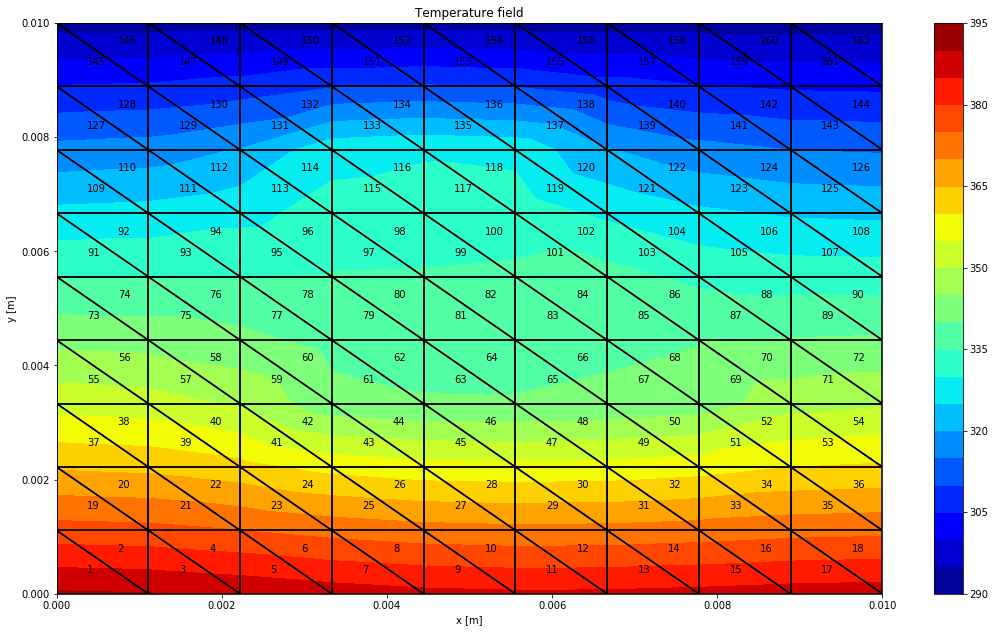

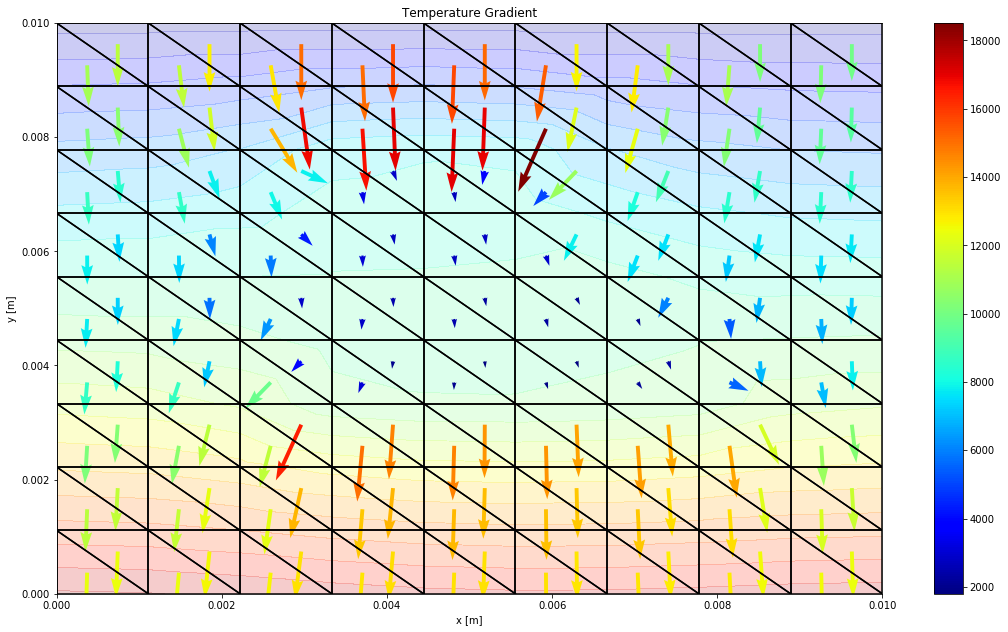

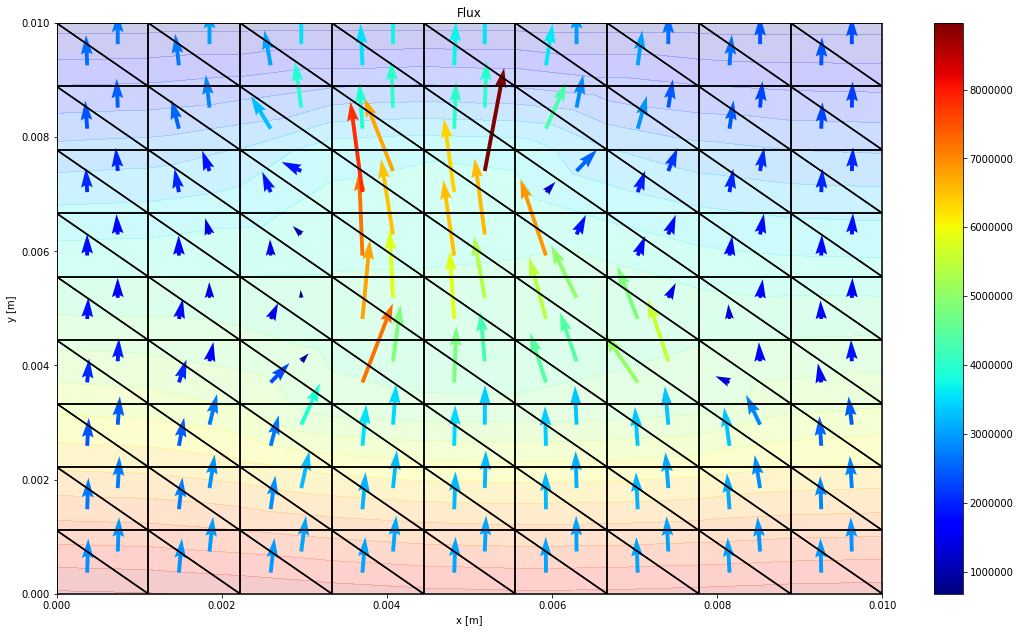

In [15]:
# Setup the simulation

# simulation parameters
L = 0.01  # [m]
hz = 0.001  # [m]
k = 236
n = 10  # number nodes in one direction (value can't be simply changed since the equation system is hardcoded)

# BCs
dirichletT = 293  # [K]
q = 3000000  # [W/m^2]

# Temperature vector
T = np.ones((n*n,1))*(-1)
for i in np.linspace(90,99,10,dtype=int):
    T[i] = dirichletT

# Load vector
P = np.zeros((n*n,1))
qPerArea = q*(L/(n-1)*hz)  # power one element sees
for i in range(10):
    P[i] = qPerArea
P[0] = qPerArea/2
P[9] = qPerArea/2

# about the parameters for Triangulation: (L... length of domain, n-1... how many elements in x and y direction
#                                          k... k, hz... element thickness, mode... 0=base mode / 1=trpezoidal 
#                                          2=bias / 4=different k, how much upper edge gets distorted in trapezoidal
#                                          can also be used for other modes, c... scale factor for k in mode 4)
Tri = Triangulation(L,n-1,n-1,k,hz,mode=4,factorV1=1,c=10)
mesh = Tri.createTriangulation()
H = mesh.assembleH()

# System of equations
T[0:90] = np.linalg.solve(H[0:90,0:90], P[0:90]-H[0:90,90:100].dot(T[90:100]))
P[90:100] = H[90:100,0:90].dot(T[0:90]) + H[90:100,90:100].dot(T[90:100])
mesh.storeT(T)

# plot contour
mesh.plotTemperatureField(numbers=True)

# plot gradient and flux
mesh.calculateTempGradient()
mesh.plotTemperatureGradient()
mesh.calculateFlux()
mesh.plotFlux()

print_HTP(H,T,P,'BaseVersion.txt')